Выбранный датасет содержит 600 000 записей в обучающем наборе и 400 000 в тестовом. Каждая запись содержит id пациента и 13 признаков:


1. Age (возраст);
2. Sex (пол);
3. Resting_blood_pressure (артериальное давление в состоянии покоя);
4. Serum_cholestoral (уровень холестерина в крови mg/dl);
5. Fasting_blood_sugar (анализ глюкозы в крови натощак (> 120 mg/dl));
6. Maximum_heart_rate_achieved (максимальная частота сердечных сокращений);
7. Exercise_induced_angina (стенокардия при нагрузке),
8. Oldpeak (депрессия ST-сегмента);
9. Slope (наклон пикового сегмента ST при физической нагрузке);
10. Number_of_major_vessels (количество крупных сосудов (0-3), окрашенных с помощью флюороскопии);
11. Resting_electrocardiographic_results (результаты электрокардиографических исследований в покое 0, 1, 2);
12. Thal (3 = норма; 6 = фиксированный дефект; 7 = обратимый дефект);
13. Chest_bin (боль в груди от 1 до 4).

In [1]:
!pip install tensorflow

In [3]:
!pip install missingno

In [4]:
# работа с данными
import pandas as pd
import numpy as np
import joblib

# визуализация данных
import seaborn as sns
import matplotlib.pyplot as plt
import missingno

# машинное обучение
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
#from xgboost import XGBClassifier

# нейронные сети
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.backend import clear_session
from tensorflow.keras.callbacks import EarlyStopping


In [5]:
print("Версия TF", tf.__version__)
print("Версия Keras", keras.__version__)

Версия TF 2.17.0
Версия Keras 3.6.0


In [6]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

In [7]:
train.shape, test.shape

((600000, 15), (400000, 14))

In [8]:
# Отображение первых 10 строк набора данных. транспонируем и округлим для визуального удобства
print(train.head(10).round(2).transpose())

                                           0       1       2       3       4  \
ID                                      0.00    1.00    2.00    3.00    4.00   
age                                    49.21   53.63   49.59   58.99   51.05   
sex                                     0.00    1.00    1.00    1.00    1.00   
chest                                   4.00    1.74    4.00    4.00    1.95   
resting_blood_pressure                163.00  130.23  147.00  112.37  138.03   
serum_cholestoral                     181.11  276.47  223.30  187.25  238.48   
fasting_blood_sugar                     0.00    0.00    1.00    0.00    0.00   
resting_electrocardiographic_results    0.00    2.00    2.00    0.00    0.00   
maximum_heart_rate_achieved           148.23  152.92  102.35  158.16  172.54   
exercise_induced_angina                 1.00    0.00    1.00    1.00    0.00   
oldpeak                                 0.94    0.12    1.62    0.00    1.15   
slope                                   

In [9]:
# Отображение первых 10 строк test набора данных. транспонируем и округлим для визуального удобства
print(test.head(10).round(2).transpose())

                                              0          1          2  \
ID                                    600000.00  600001.00  600002.00   
age                                       53.96      49.62      36.93   
sex                                        1.00       1.00       1.00   
chest                                      4.00       4.00       1.30   
resting_blood_pressure                   136.94     122.02     127.59   
serum_cholestoral                        236.86     226.59     351.06   
fasting_blood_sugar                        0.00       0.00       0.00   
resting_electrocardiographic_results       2.00       2.00       0.00   
maximum_heart_rate_achieved              143.96     112.22     177.95   
exercise_induced_angina                    1.00       1.00       0.00   
oldpeak                                    0.71       0.00       0.31   
slope                                      1.00       1.00       1.00   
number_of_major_vessels                    2.00    

In [10]:
train.info(), test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600000 entries, 0 to 599999
Data columns (total 15 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   ID                                    600000 non-null  int64  
 1   age                                   600000 non-null  float64
 2   sex                                   600000 non-null  int64  
 3   chest                                 600000 non-null  float64
 4   resting_blood_pressure                600000 non-null  float64
 5   serum_cholestoral                     600000 non-null  float64
 6   fasting_blood_sugar                   600000 non-null  int64  
 7   resting_electrocardiographic_results  600000 non-null  int64  
 8   maximum_heart_rate_achieved           600000 non-null  float64
 9   exercise_induced_angina               600000 non-null  int64  
 10  oldpeak                               600000 non-null  float64
 11  

(None, None)

<Axes: >

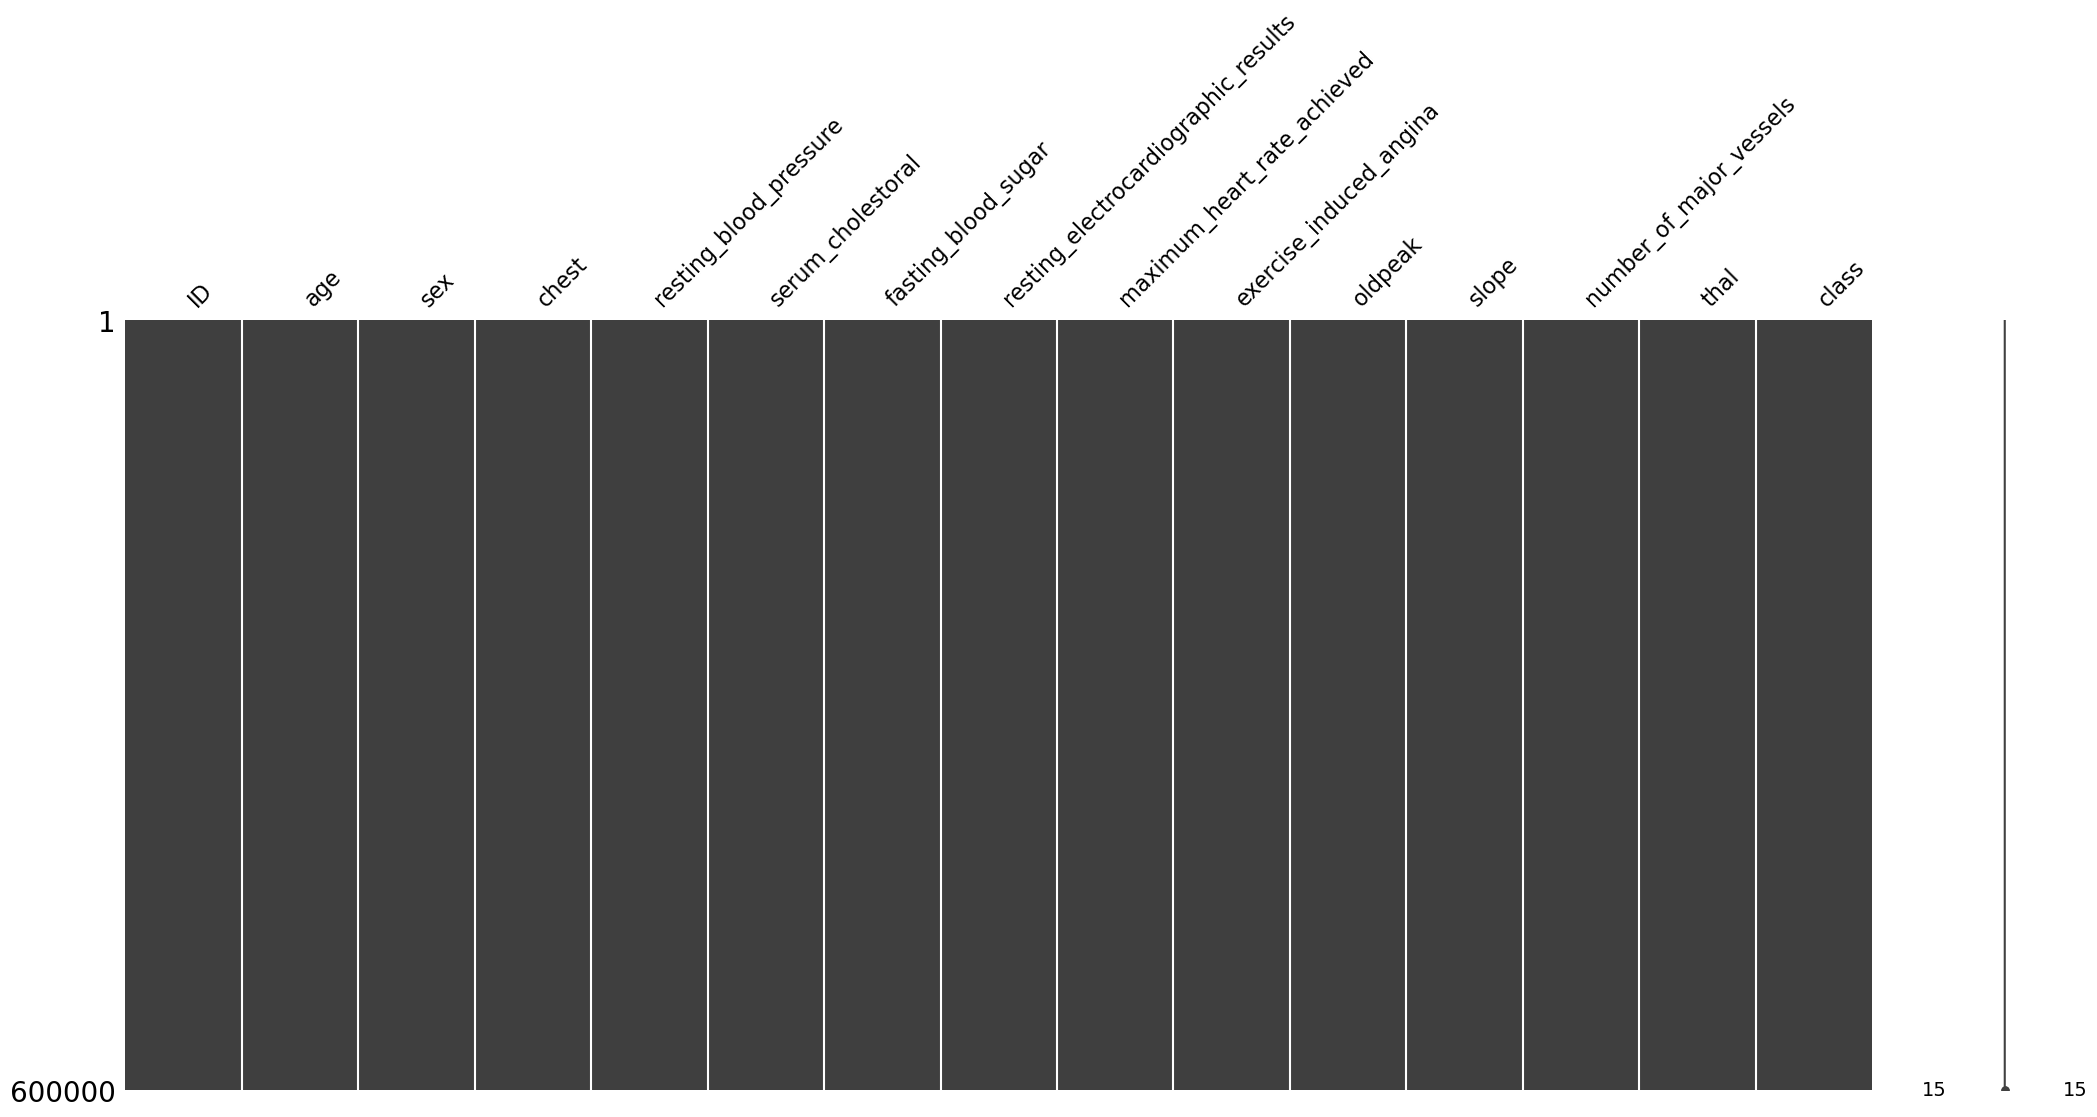

In [11]:
missingno.matrix(train) #визуальный анализ на пропуски

<Axes: >

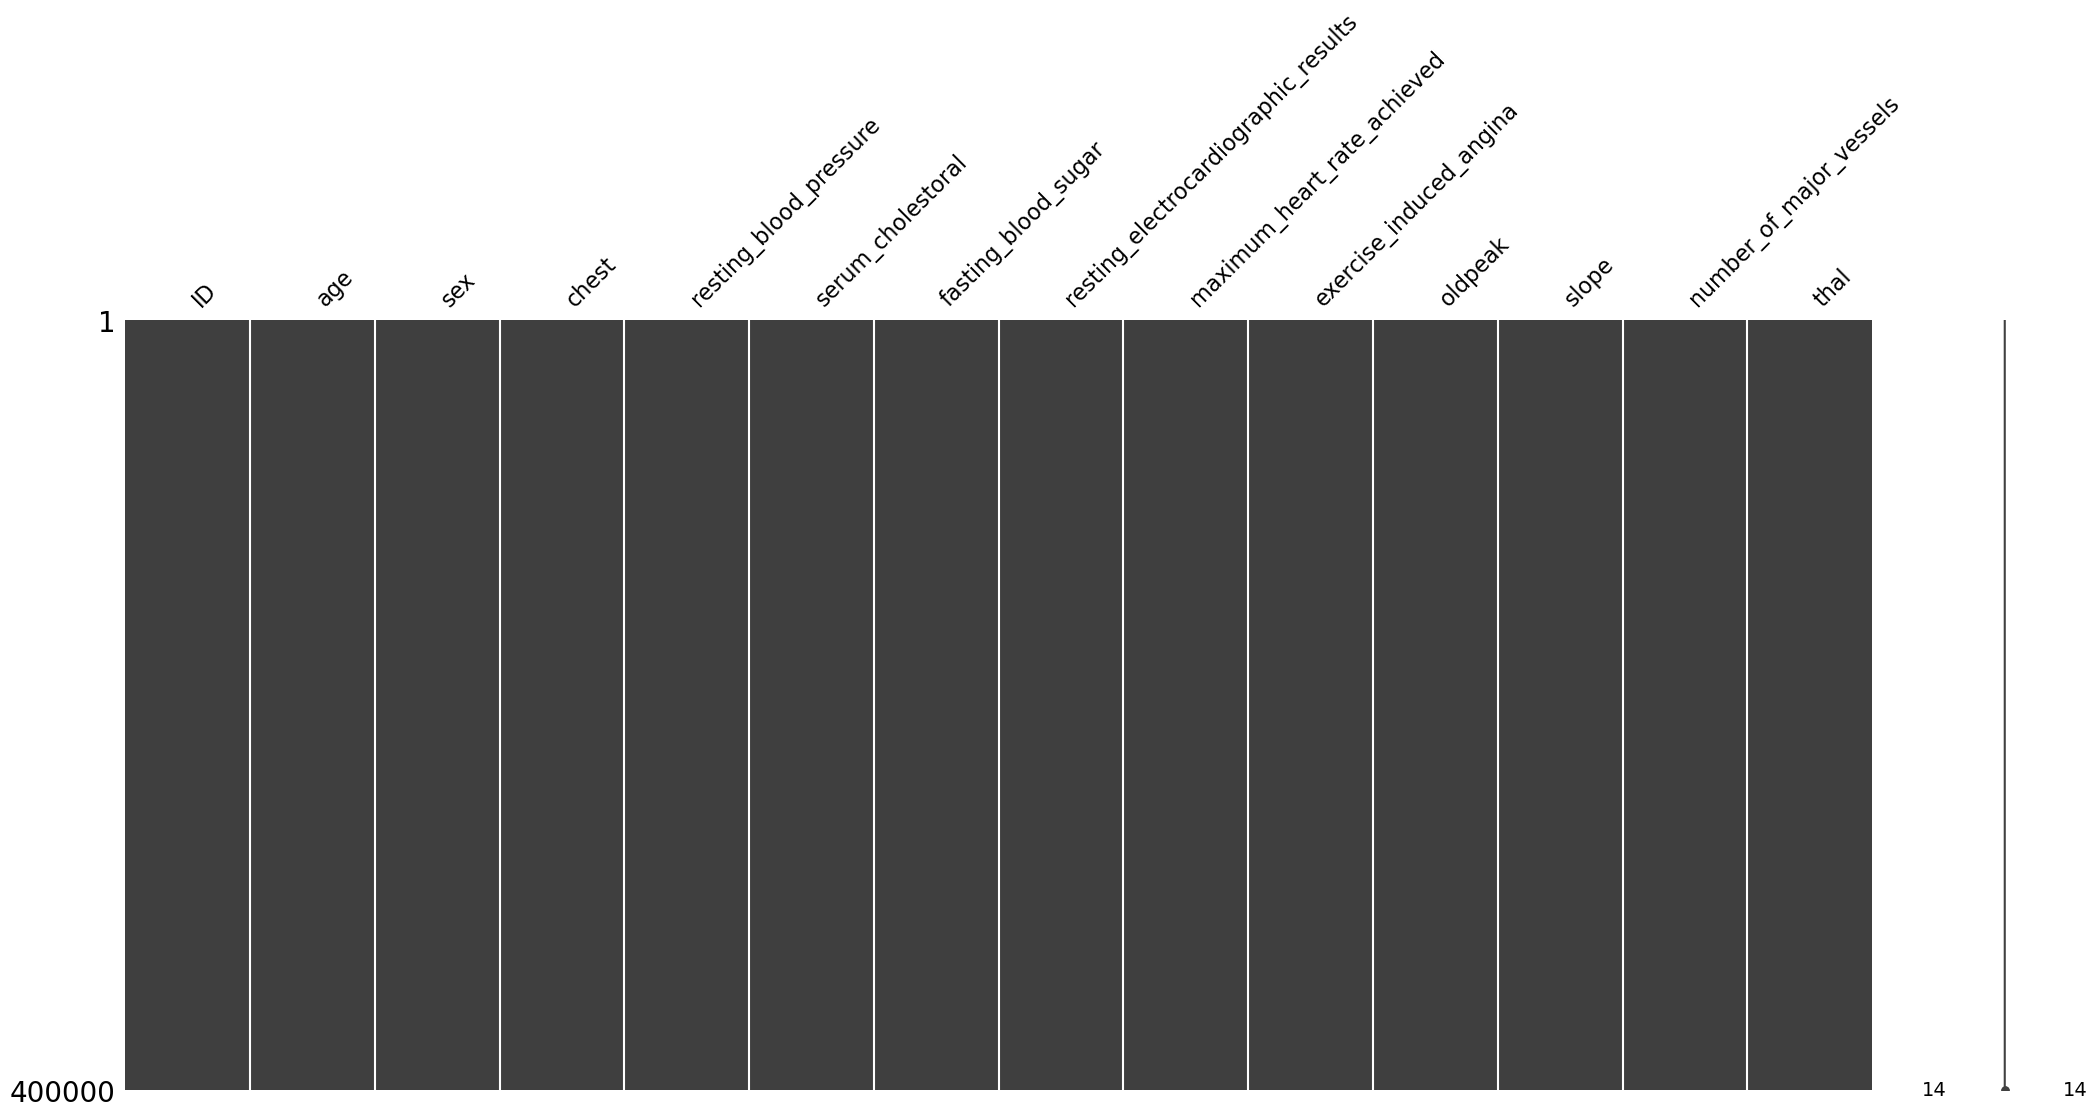

In [12]:
missingno.matrix(test)

In [13]:
# проверка на дубликаты
train.duplicated().sum()


0

In [14]:
test.duplicated().sum()

0

In [15]:
train.describe().round(2).transpose()

,count,mean,std,min,25%,50%,75%,max
ID,600000.0,299999.50,173205.23,0.00,149999.75,299999.50,449999.25,599999.00
age,600000.0,54.43,9.09,26.06,48.08,55.13,60.66,79.59
sex,600000.0,0.68,0.47,0.00,0.00,1.00,1.00,1.00
chest,600000.0,3.17,0.95,-0.54,3.00,3.00,4.00,4.00
resting_blood_pressure,600000.0,131.34,17.84,82.92,119.92,129.73,139.92,209.67
serum_cholestoral,600000.0,249.59,51.70,98.33,216.48,244.23,274.35,527.76
fasting_blood_sugar,600000.0,0.15,0.36,0.00,0.00,0.00,0.00,1.00
resting_electrocardiographic_results,600000.0,1.02,0.99,0.00,0.00,2.00,2.00,2.00
maximum_heart_rate_achieved,600000.0,149.59,23.07,61.84,135.70,153.22,165.17,208.74
exercise_induced_angina,600000.0,0.33,0.47,0.00,0.00,0.00,1.00,1.00


In [16]:
test.describe().round(2).transpose()

,count,mean,std,min,25%,50%,75%,max
ID,400000.0,799999.50,115470.20,600000.00,699999.75,799999.50,899999.25,999999.00
age,400000.0,54.41,9.10,27.50,48.02,55.13,60.67,80.75
sex,400000.0,0.68,0.47,0.00,0.00,1.00,1.00,1.00
chest,400000.0,3.17,0.95,-0.34,3.00,3.00,4.00,4.00
resting_blood_pressure,400000.0,131.37,17.86,85.83,119.94,129.74,139.94,212.30
serum_cholestoral,400000.0,249.59,51.72,94.96,216.46,244.27,274.36,527.71
fasting_blood_sugar,400000.0,0.15,0.36,0.00,0.00,0.00,0.00,1.00
resting_electrocardiographic_results,400000.0,1.03,0.99,0.00,0.00,2.00,2.00,2.00
maximum_heart_rate_achieved,400000.0,149.66,23.07,58.96,135.82,153.34,165.22,207.41
exercise_induced_angina,400000.0,0.33,0.47,0.00,0.00,0.00,1.00,1.00


**Дубликаты и пропущенные значения отсуствуют**

# Предобработка признаков
**Проанализируем вручную признаки, какие лучше перевести в тип object, чтобы избежать искажения нашей моделив будущем алгоритме**
 1.   age                                   float64 числовой признак, оставляем, релевантен
 2.   sex                                   int64  переведем в object, это категориальный признак
 3.   chest                                 float64 числовой
 4.   resting_blood_pressure                float64 числовой, стоит посмотреть выбросы
 5.   serum_cholestoral                     float64 числовой , смотрим нормы
 6.   fasting_blood_sugar                   int64 категориальный, так как таких референсов нет на диагностических показателях,  переведем в object
 7.   resting_electrocardiographic_results  int64  категориальный,  переведем в object
 8.   maximum_heart_rate_achieved           float64 числовой
 9.   exercise_induced_angina               int64 категориальный,  переведем в object  
 10.  oldpeak                               float64 числовой, депрессия может быть в любую сторону, поэтому и выбросы условны
 11.  slope                                 int64  категориальный,  переведем в object  
 12. number_of_major_vessels                 категориальный,  переведем в object  
 13.  thal                                  int64   категориальный,  переведем в object  
 14. class                                  int64  целевой признак

In [17]:
train= train.drop(columns=['ID'])
test= test.drop(columns=['ID'])

In [18]:
#по вышеописанному сценарию создаём список для перевода в object переменных
cat_list = ([
  'sex',
  'fasting_blood_sugar',
  'resting_electrocardiographic_results',
  'exercise_induced_angina',
  'slope',
  'number_of_major_vessels',
  'thal'
  ])
# циклом переводим в тип object
for elem in cat_list:
  train[elem] = train[elem].astype(object)

In [61]:
# выделяем отдельно столбцы с количественными переменными
num_cols = train.select_dtypes(include=['number']).columns

In [62]:
train.info() #смотрим результат

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600000 entries, 0 to 599999
Data columns (total 14 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   age                                   600000 non-null  float64
 1   sex                                   600000 non-null  object 
 2   chest                                 600000 non-null  float64
 3   resting_blood_pressure                600000 non-null  float64
 4   serum_cholestoral                     600000 non-null  float64
 5   fasting_blood_sugar                   600000 non-null  object 
 6   resting_electrocardiographic_results  600000 non-null  object 
 7   maximum_heart_rate_achieved           600000 non-null  float64
 8   exercise_induced_angina               600000 non-null  object 
 9   oldpeak                               600000 non-null  float64
 10  slope                                 600000 non-null  object 
 11  

In [63]:
#аналогично для тестовой выборки
cat_list_test = ([
  'sex',
  'fasting_blood_sugar',
  'resting_electrocardiographic_results',
  'exercise_induced_angina',
  'slope',
  'number_of_major_vessels',
  'thal'
  ])
# циклом переводим в тип object
for elem in cat_list_test:
  test[elem] = test[elem].astype(object)

In [64]:
# выделяем отдельно столбцы с количественными переменными
num_cols_test = test.select_dtypes(include=['number']).columns

In [65]:
test.info() #смотрим результат

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400000 entries, 0 to 399999
Data columns (total 13 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   age                                   400000 non-null  float64
 1   sex                                   400000 non-null  object 
 2   chest                                 400000 non-null  float64
 3   resting_blood_pressure                400000 non-null  float64
 4   serum_cholestoral                     400000 non-null  float64
 5   fasting_blood_sugar                   400000 non-null  object 
 6   resting_electrocardiographic_results  400000 non-null  object 
 7   maximum_heart_rate_achieved           400000 non-null  float64
 8   exercise_induced_angina               400000 non-null  object 
 9   oldpeak                               400000 non-null  float64
 10  slope                                 400000 non-null  object 
 11  

In [66]:
# Разделение данных на категориальные и числовые
num_data = train.select_dtypes(include=np.number)
cat_data = train.select_dtypes(exclude=np.number)

num_data_test = test.select_dtypes(include=np.number)
cat_data_test = test.select_dtypes(exclude=np.number)

In [67]:
num_data.columns, cat_data.columns

(Index(['age', 'chest', 'resting_blood_pressure', 'serum_cholestoral',
        'maximum_heart_rate_achieved', 'oldpeak', 'class'],
       dtype='object'),
 Index(['sex', 'fasting_blood_sugar', 'resting_electrocardiographic_results',
        'exercise_induced_angina', 'slope', 'number_of_major_vessels', 'thal'],
       dtype='object'))

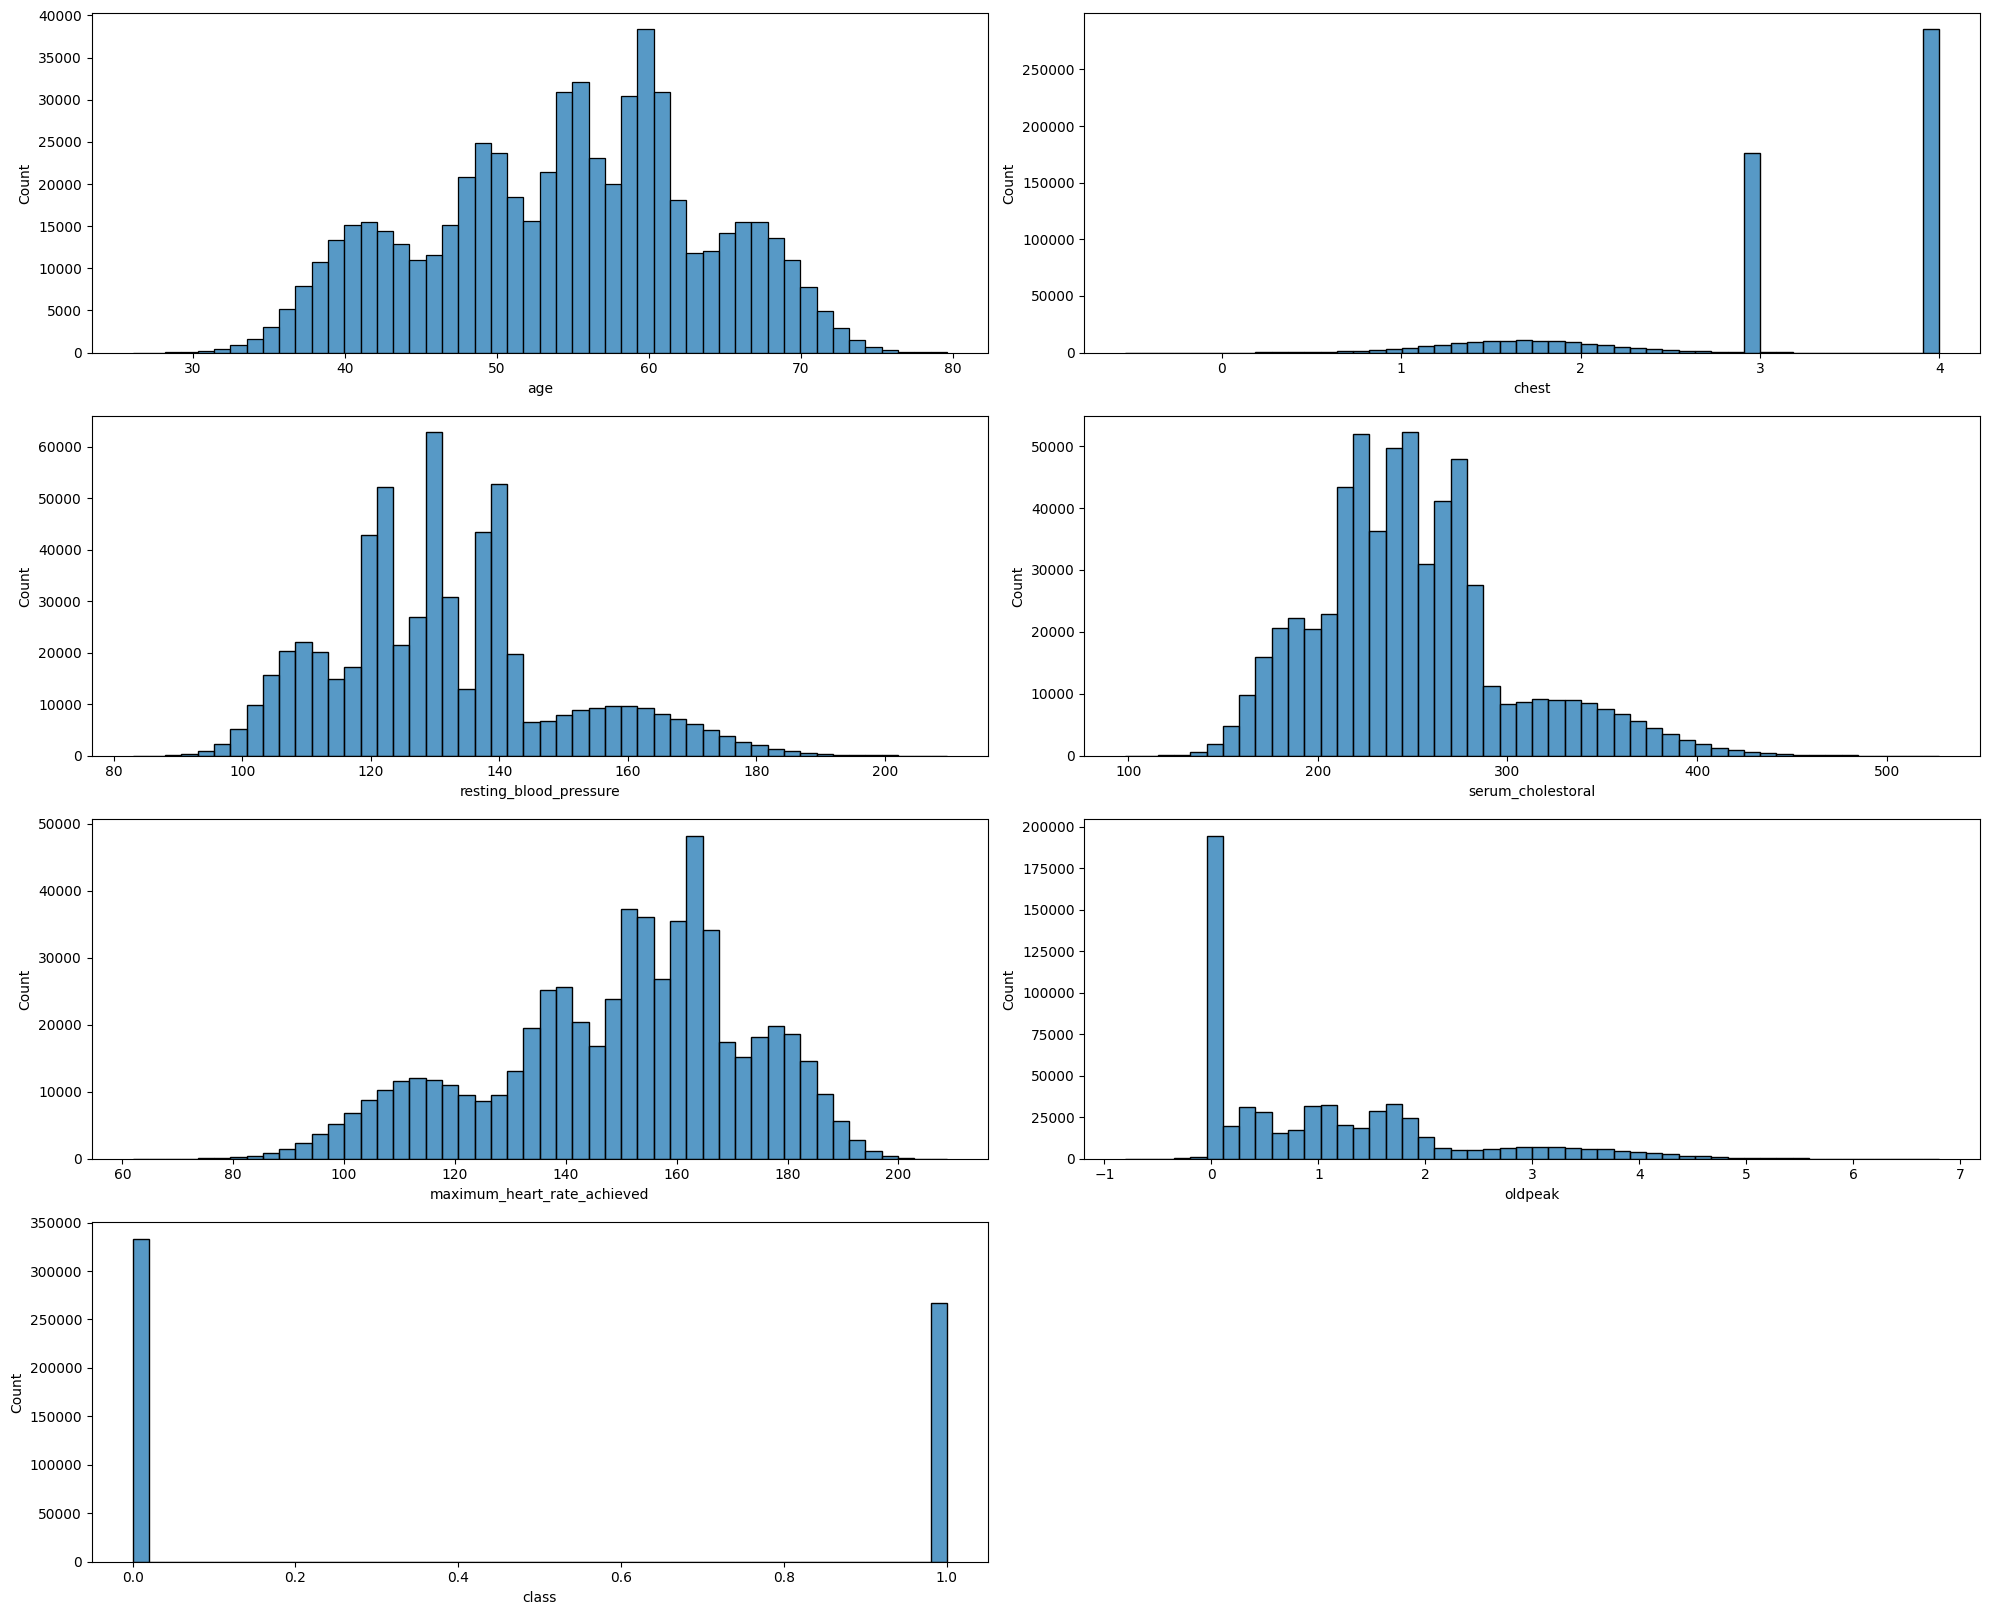

In [68]:
# гистограммы для числовых переменных
plt.figure(figsize=(20, 40), dpi=100)

for i, column in enumerate(num_data, start=1):
    plt.subplot(10, 2, i)
    sns.histplot(data=num_data, x=column, bins=50)
    plt.tight_layout()

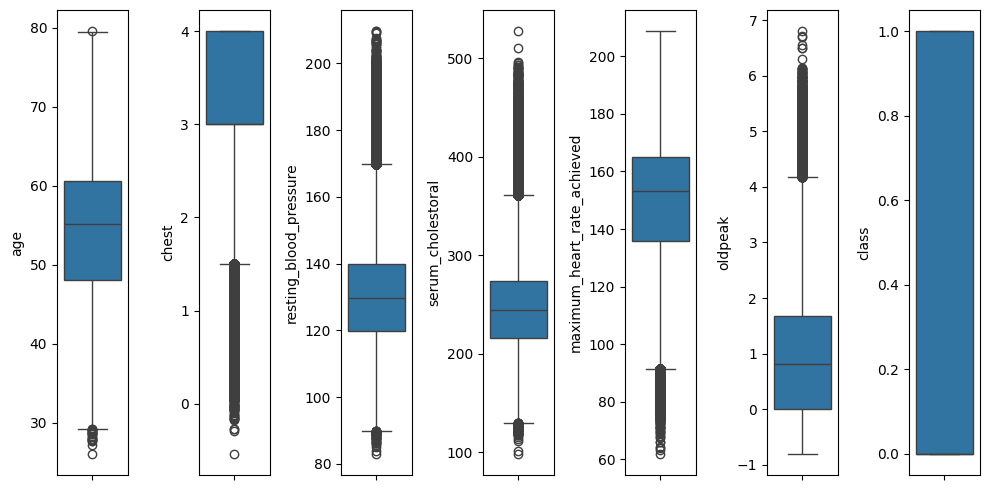

In [69]:
# Проверка числовых данных на выбросы
col_num = num_data.columns
plt.figure(figsize=(10,5))
for i in range(0,len(col_num)):
    plt.subplot(1,len(col_num),i+1)
    sns.boxplot(y=train[col_num[i]])
    plt.tight_layout()

**в числовых данных скорее нет выбросов, оставим как есть**

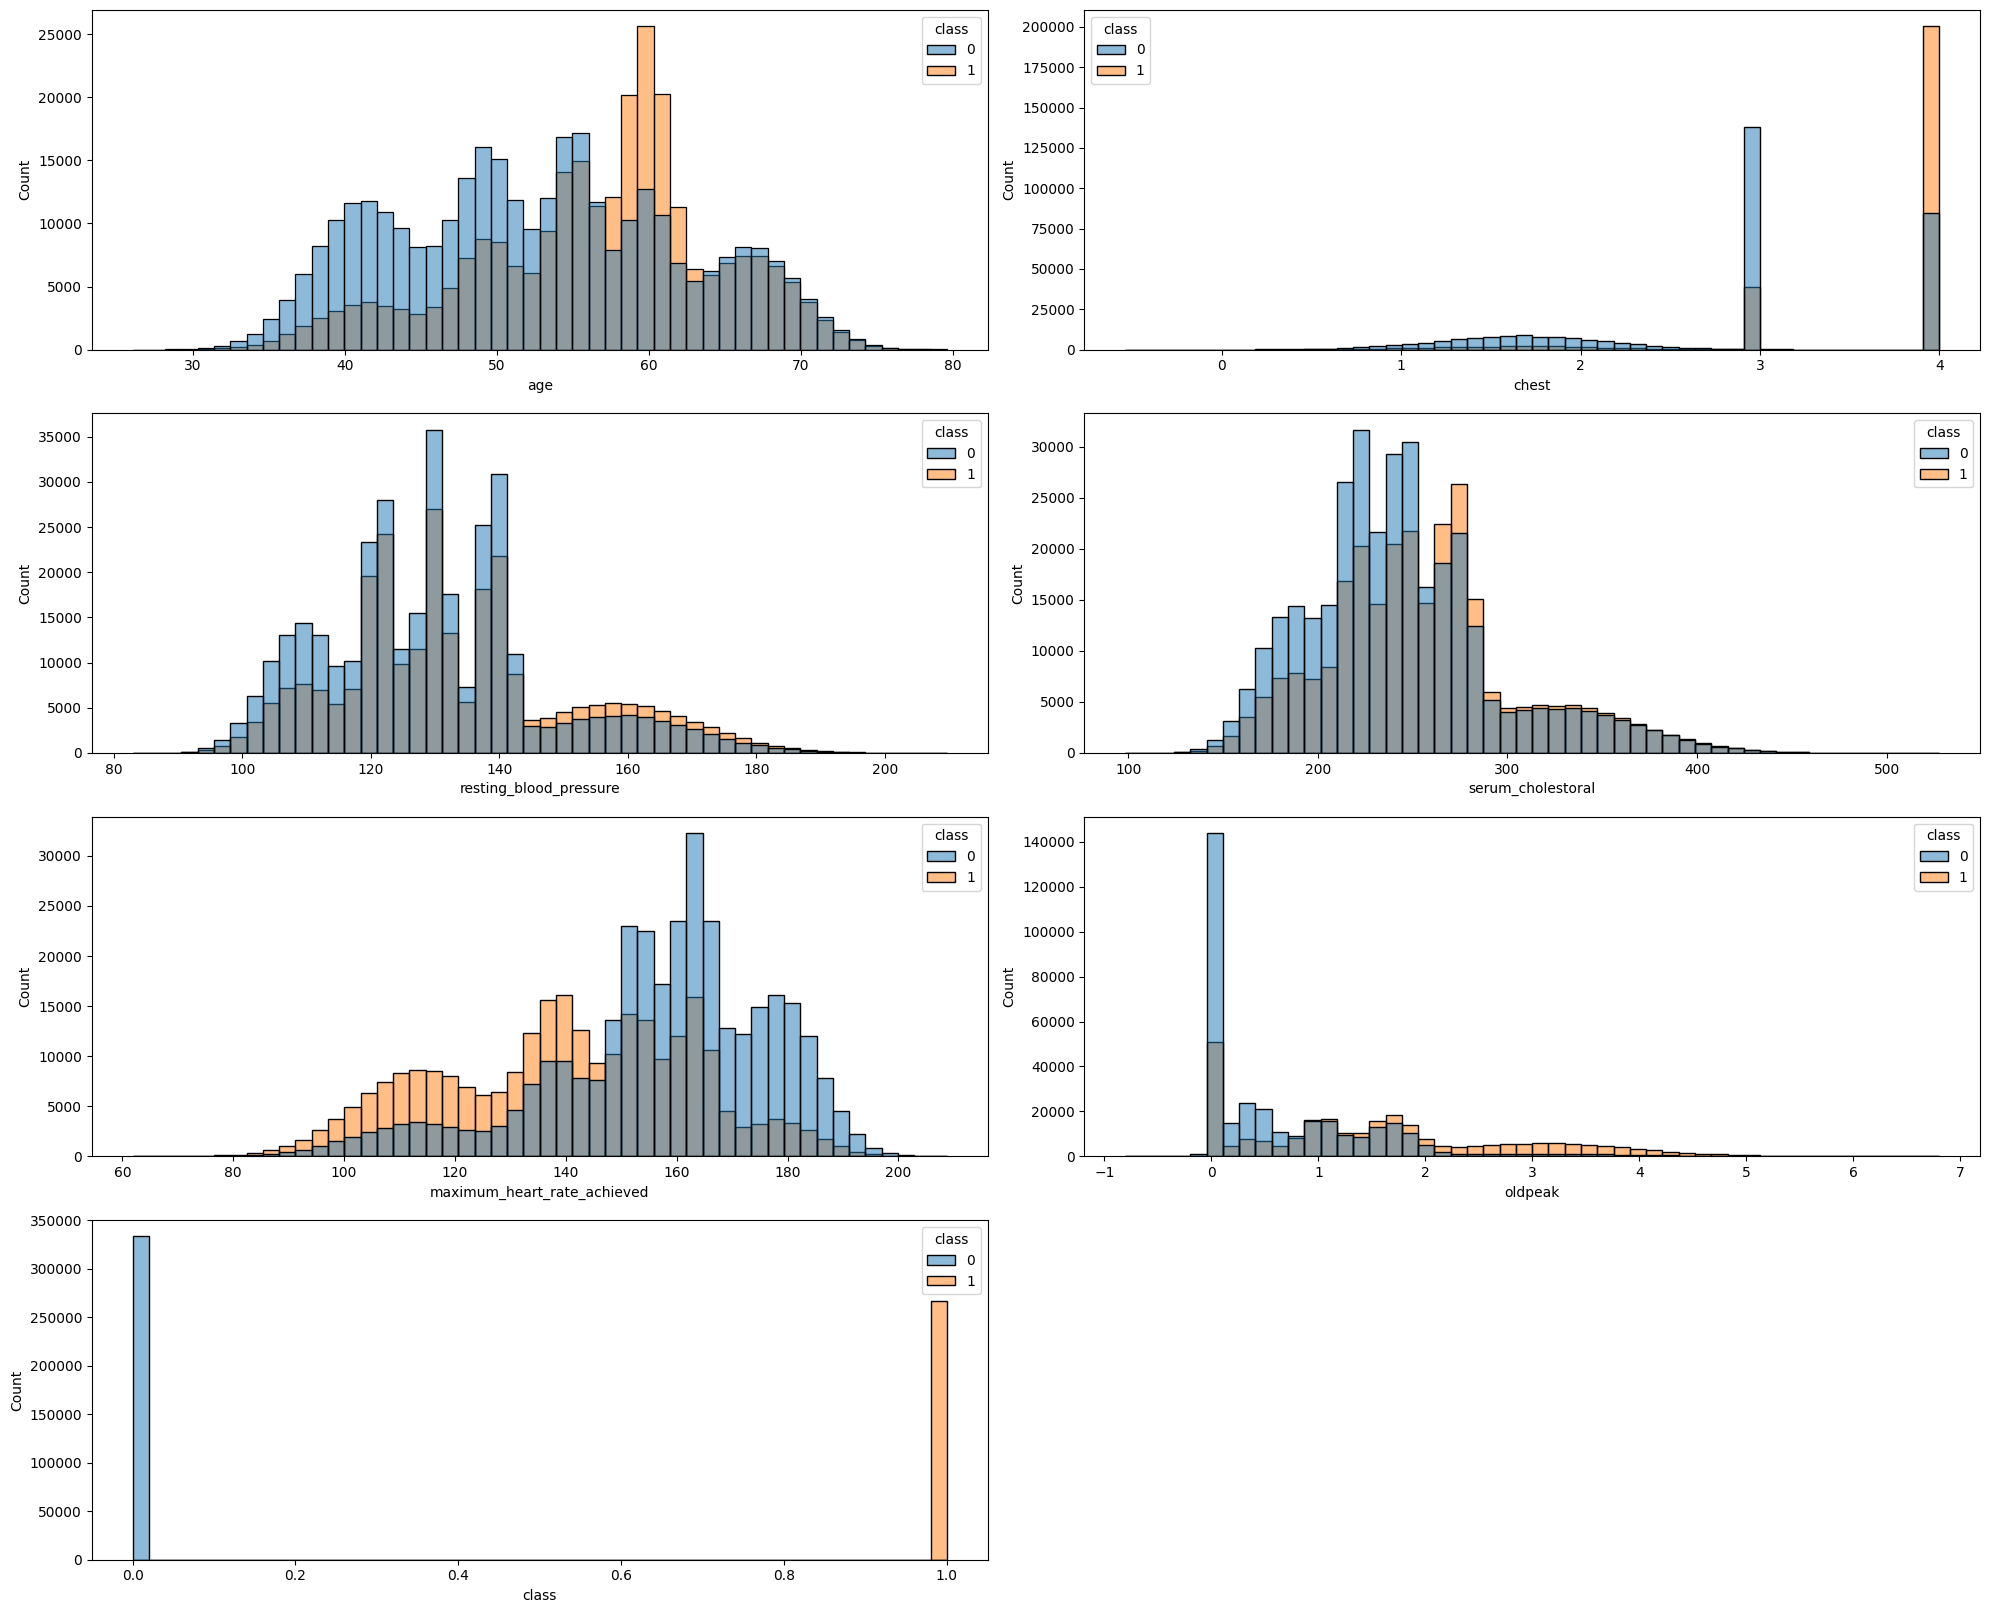

In [70]:
# смотрим на целевую переменную 'class' в числовых признаках
plt.figure(figsize=(20, 40), dpi=100)

for i, column in enumerate(num_data, start=1):
    plt.subplot(10, 2, i)
    sns.histplot(data=num_data, x=column, hue='class', bins=50)
    plt.tight_layout()

**Визуально очень хорошо видно, что *чем выше* возраст, боль в груди, показатель давления в покое, уровень холестерина, деперссии сегмента ST тем вероятнее болезнь**

а вот частота сердечных сокращений снижена относительно целевого показателя, что характерно, например, водители ритма, такие как пучок Гиса могут иметь нарушение проводимости и соотвественно возбудимости миокарада. Этот момент требует исследований

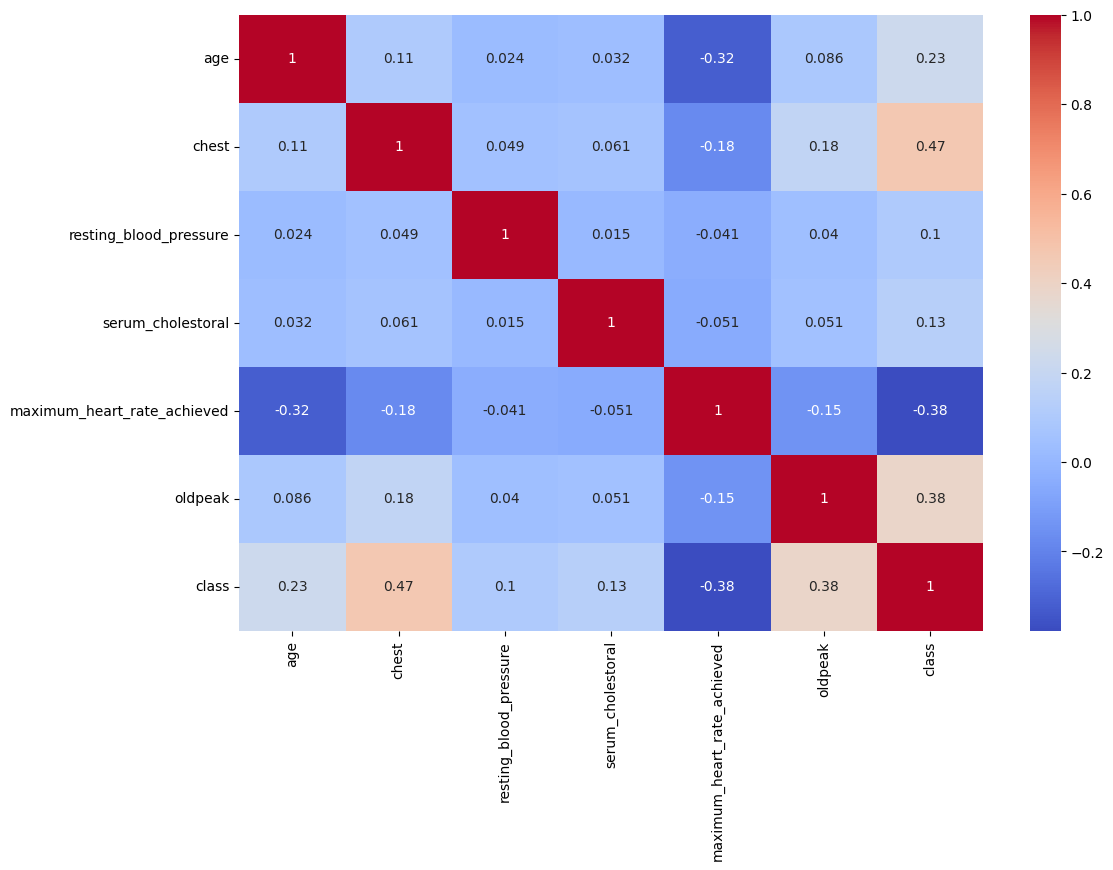

In [71]:
# Корреляция числовых данных на correlation matrix
corr_matrix = train.select_dtypes(include=np.number).corr(method='spearman')

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

**Боль в груди и депрессия сегмента ST на ЭКГ наиболее коррелируют с целевым признаком наличия болезни**

опять видим, что урежение ритма так же даёт вероятность болезни, на матрице это отражается отрицательным значением. Вероятнее всего здесь зависимость в том, что возбудимость клеток миокарда, с уже с наличием депрессии сегмента ST (это ишемия или перенесенное заболевание, характеризует рубец или выключение нижнего объёма сердца), этот момент, *возможно характеризует вероятность повторного инфаркта.*

In [72]:
# Смотрим уникальные значнения в категориальных переменных, которые мы ранее вручную выделии в отдельный список
for i in cat_list:
    if i in train.columns:
        print('Уникальные значения в колонке {0} : \n{1}'.format(i, train[i].value_counts().sort_index()))
        print('\n')
    else:
        print(f'Column {i} not found in the DataFrame.')

# Print the list of categorical columns
print('Categorical columns:', cat_list)

Уникальные значения в колонке sex : 
sex
0    193532
1    406468
Name: count, dtype: int64


Уникальные значения в колонке fasting_blood_sugar : 
fasting_blood_sugar
0    509546
1     90454
Name: count, dtype: int64


Уникальные значения в колонке resting_electrocardiographic_results : 
resting_electrocardiographic_results
0    290609
1      6693
2    302698
Name: count, dtype: int64


Уникальные значения в колонке exercise_induced_angina : 
exercise_induced_angina
0    399899
1    200101
Name: count, dtype: int64


Уникальные значения в колонке slope : 
slope
1    289149
2    264082
3     46769
Name: count, dtype: int64


Уникальные значения в колонке number_of_major_vessels : 
number_of_major_vessels
0    353137
1    129017
2     73773
3     44073
Name: count, dtype: int64


Уникальные значения в колонке thal : 
thal
3    334624
6     34677
7    230699
Name: count, dtype: int64


Categorical columns: ['sex', 'fasting_blood_sugar', 'resting_electrocardiographic_results', 'exercise_ind

In [73]:
# перевод категориальных переменных в дамми-переменные
train_mod = pd.get_dummies(
    train,
    columns=cat_list,
    dtype='int',
    drop_first=True
)

In [116]:
# перевод категориальных переменных в дамми-переменные
test_mod = pd.get_dummies(
    test,
    columns=cat_list,
    dtype='int',
    drop_first=True
)

In [75]:
train_mod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600000 entries, 0 to 599999
Data columns (total 19 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   age                                     600000 non-null  float64
 1   chest                                   600000 non-null  float64
 2   resting_blood_pressure                  600000 non-null  float64
 3   serum_cholestoral                       600000 non-null  float64
 4   maximum_heart_rate_achieved             600000 non-null  float64
 5   oldpeak                                 600000 non-null  float64
 6   class                                   600000 non-null  int64  
 7   sex_1                                   600000 non-null  int64  
 8   fasting_blood_sugar_1                   600000 non-null  int64  
 9   resting_electrocardiographic_results_1  600000 non-null  int64  
 10  resting_electrocardiographic_results_2  6000

In [117]:
test_mod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400000 entries, 0 to 399999
Data columns (total 18 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   age                                     400000 non-null  float64
 1   chest                                   400000 non-null  float64
 2   resting_blood_pressure                  400000 non-null  float64
 3   serum_cholestoral                       400000 non-null  float64
 4   maximum_heart_rate_achieved             400000 non-null  float64
 5   oldpeak                                 400000 non-null  float64
 6   sex_1                                   400000 non-null  int64  
 7   fasting_blood_sugar_1                   400000 non-null  int64  
 8   resting_electrocardiographic_results_1  400000 non-null  int64  
 9   resting_electrocardiographic_results_2  400000 non-null  int64  
 10  exercise_induced_angina_1               4000

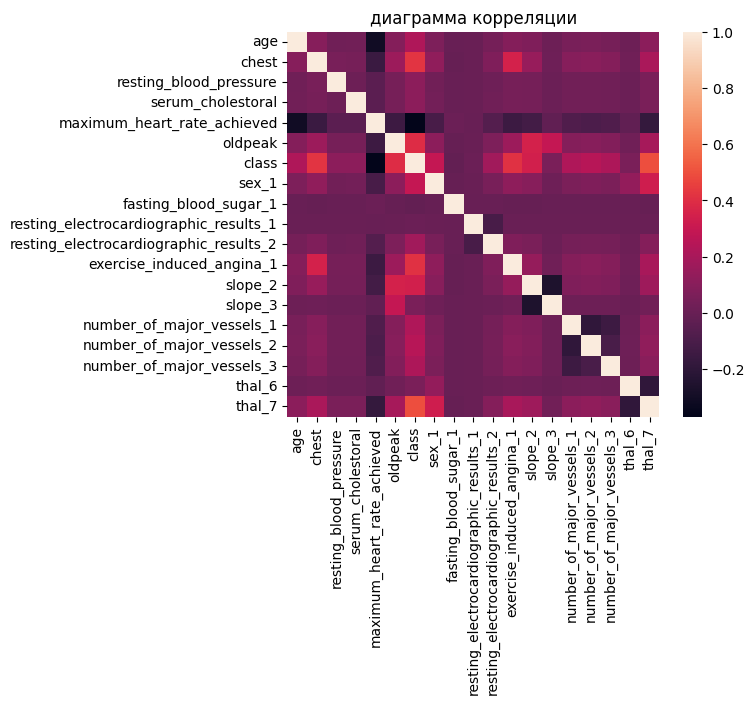

In [77]:
# построение диаграммы корреляции для обновленного датасета
plt.figure(figsize=(6, 5), dpi=100)
plt.title("диаграмма корреляции")
sns.heatmap(train_mod.corr(), annot=False, fmt = '0.1f');

In [78]:
# Разделение данных на features и target
X = train_mod.drop('class', axis=1)
y = train_mod['class']

In [79]:
# Разделение на train и test датасеты
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [80]:
# Инициализация StandardScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [81]:
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()



In [118]:
test_mod_scaled = test_mod.copy() # не забываем про тестовый набор данных, ранее мы дамми преобразование сделали

In [121]:
# Выделение числовых данных для стандартизации
numeric_columns = X_train.select_dtypes(include=np.number).columns

numeric_columns_test = test_mod_scaled.select_dtypes(include=np.number).columns

In [122]:
# Стандартизация числовых данных
X_train_scaled[numeric_columns] = scaler.fit_transform(X_train[numeric_columns])
X_test_scaled[numeric_columns] = scaler.transform(X_test[numeric_columns])



In [123]:
test_mod_scaled[numeric_columns_test] = scaler.fit_transform(test_mod_scaled[numeric_columns_test])

In [84]:
X_train_scaled.shape, X_test_scaled.shape, y_train.shape

((480000, 18), (120000, 18), (480000,))

In [85]:
y_train.value_counts()

,count
class,
0,266677
1,213323


In [124]:
test_mod_scaled.shape

(400000, 18)

# Модели

**RandomForestClassifier**

In [87]:
# Инициализация RandomForestClassifier
RFC_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Обучение модели на train датасете
RFC_model.fit(X_train_scaled, y_train)

# Валидация
y_pred1 = RFC_model.predict(X_test_scaled)

In [88]:
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Вычисление MAE
mae = mean_absolute_error(y_test, y_pred1)
print(f"Mean Absolute Error (MAE): {mae}")

# Вычисление accuracy
accuracy = accuracy_score(y_test, y_pred1)
print("Accuracy:", accuracy)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred1)
print("Confusion Matrix:\n", conf_matrix)

# Classification report
class_report = classification_report(y_test, y_pred1)
print("Classification Report:\n", class_report)

Mean Absolute Error (MAE): 0.10333333333333333
Accuracy: 0.8966666666666666
Confusion Matrix:
 [[61089  5723]
 [ 6677 46511]]
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.91      0.91     66812
           1       0.89      0.87      0.88     53188

    accuracy                           0.90    120000
   macro avg       0.90      0.89      0.90    120000
weighted avg       0.90      0.90      0.90    120000



In [89]:
# Инициализация Logistic Regression
logreg = LogisticRegression(
    penalty='l2',        # регуляризация
    C=1.0,               # regularization strength
    solver='lbfgs',      # оптимайзер для регуляризации
    max_iter=100,        # максимальное количество итераций
    random_state=42
)

# Обучение модели
logreg.fit(X_train_scaled, y_train)

# Валидация
y_pred2 = logreg.predict(X_test_scaled)

In [90]:
# Вычисление MAE
mae = mean_absolute_error(y_test, y_pred2)
print(f"Mean Absolute Error (MAE): {mae}")

# Вычисление accuracy
accuracy = accuracy_score(y_test, y_pred2)
print("Accuracy:", accuracy)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred2)
print("Confusion Matrix:\n", conf_matrix)

# Classification report
class_report = classification_report(y_test, y_pred2)
print("Classification Report:\n", class_report)

Mean Absolute Error (MAE): 0.11601666666666667
Accuracy: 0.8839833333333333
Confusion Matrix:
 [[60405  6407]
 [ 7515 45673]]
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.90      0.90     66812
           1       0.88      0.86      0.87     53188

    accuracy                           0.88    120000
   macro avg       0.88      0.88      0.88    120000
weighted avg       0.88      0.88      0.88    120000



### The neural network (Sequental)

In [91]:
# очистка сессии
clear_session()

In [92]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [93]:
from tensorflow.keras import layers, callbacks

early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # min изменение, которое считается возрастанием
    patience=10, # сколько сделать перед остановкой
    restore_best_weights=True,
)

In [94]:
# Определение модели neural network
model = Sequential()

In [95]:
input_shape = X_train_scaled.shape[1]

In [96]:
# Input layer и hidden layers
model.add(Dense(64, input_dim=input_shape, activation='relu'))  # Input layer
model.add(Dense(32, activation='relu'))  # Hidden layer
model.add(Dense(16, activation='relu'))  # Hidden layer

# Output layer
model.add(Dense(1, activation='sigmoid'))

In [97]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1216      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 3,841
Trainable params: 3,841
Non-trainable params: 0
_________________________________________________________________


In [98]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [99]:
# Обучение модели
history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_data=(X_test_scaled, y_test),callbacks=[early_stopping])

Epoch 1/50
15000/15000 [==============================] - 32s 2ms/step - loss: 0.2586 - accuracy: 0.8927 - val_loss: 0.2523 - val_accuracy: 0.8960
Epoch 2/50
15000/15000 [==============================] - 30s 2ms/step - loss: 0.2499 - accuracy: 0.8969 - val_loss: 0.2504 - val_accuracy: 0.8966
Epoch 3/50
15000/15000 [==============================] - 34s 2ms/step - loss: 0.2478 - accuracy: 0.8979 - val_loss: 0.2498 - val_accuracy: 0.8972
Epoch 4/50
15000/15000 [==============================] - 32s 2ms/step - loss: 0.2466 - accuracy: 0.8982 - val_loss: 0.2495 - val_accuracy: 0.8977
Epoch 5/50
15000/15000 [==============================] - 30s 2ms/step - loss: 0.2456 - accuracy: 0.8988 - val_loss: 0.2494 - val_accuracy: 0.8976
Epoch 6/50
15000/15000 [==============================] - 30s 2ms/step - loss: 0.2447 - accuracy: 0.8994 - val_loss: 0.2468 - val_accuracy: 0.8988
Epoch 7/50
15000/15000 [==============================] - 33s 2ms/step - loss: 0.2440 - accuracy: 0.8994 - val_loss: 0

In [100]:
# Валидация
y_pred_prob = model.predict(X_test_scaled)
y_pred3 = (y_pred_prob > 0.5).astype(int)  # конвертация предсказанных вероятностей в бинарный класс (0 или 1)

In [101]:
# Оценка
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print(f'Test Accuracy: {accuracy}')

3750/3750 [==============================] - 5s 1ms/step - loss: 0.2425 - accuracy: 0.9000
Test Accuracy: 0.8999916911125183


In [102]:
# Вычисление MAE
mae = mean_absolute_error(y_test, y_pred3)
print(f"Mean Absolute Error (MAE): {mae}")

# Вычисление accuracy
accuracy = accuracy_score(y_test, y_pred3)
print("Accuracy:", accuracy)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred3)
print("Confusion Matrix:\n", conf_matrix)

# Classification report
class_report = classification_report(y_test, y_pred3)
print("Classification Report:\n", class_report)

Mean Absolute Error (MAE): 0.10000833333333334
Accuracy: 0.8999916666666666
Confusion Matrix:
 [[61201  5611]
 [ 6390 46798]]
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.92      0.91     66812
           1       0.89      0.88      0.89     53188

    accuracy                           0.90    120000
   macro avg       0.90      0.90      0.90    120000
weighted avg       0.90      0.90      0.90    120000



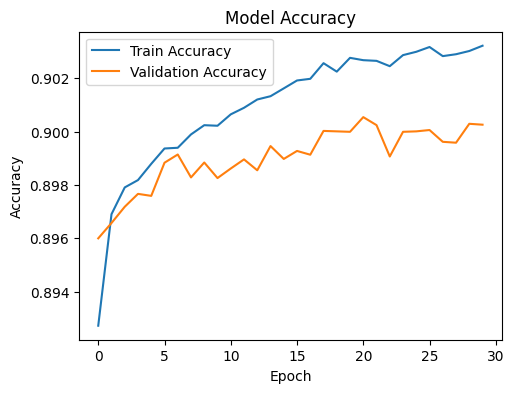

In [103]:
# График обучения
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

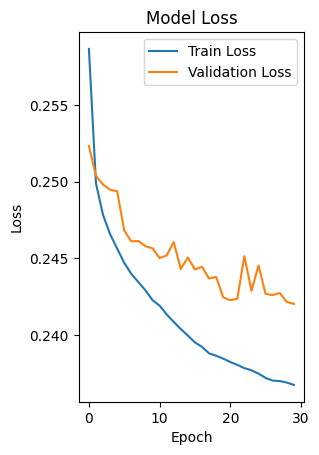

In [104]:
# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.show()

In [105]:
# Сохранение модели нейронной сети
model.save('NN_model.keras')

In [126]:
X_test_pre = test_mod_scaled

In [127]:
X_test_pre.head()

,age,chest,resting_blood_pressure,serum_cholestoral,maximum_heart_rate_achieved,oldpeak,sex_1,fasting_blood_sugar_1,resting_electrocardiographic_results_1,resting_electrocardiographic_results_2,exercise_induced_angina_1,slope_2,slope_3,number_of_major_vessels_1,number_of_major_vessels_2,number_of_major_vessels_3,thal_6,thal_7
0,-0.048756,0.873934,0.311897,-0.246144,-0.247013,-0.297099,0.690953,-0.421997,-0.105777,0.985870,1.415004,-0.888561,-0.288704,-0.523658,2.667594,-0.281176,-0.249427,1.269614
1,-0.525813,0.873934,-0.523170,-0.444707,-1.623099,-0.920333,0.690953,-0.421997,-0.105777,0.985870,1.415004,-0.888561,-0.288704,1.909642,-0.374870,-0.281176,-0.249427,1.269614
2,-1.919895,-1.965453,-0.211844,1.961846,1.226350,-0.645940,0.690953,-0.421997,-0.105777,-1.014333,-0.706712,-0.888561,-0.288704,-0.523658,-0.374870,-0.281176,-0.249427,1.269614
3,0.052485,-0.178051,-0.363498,0.015024,0.152495,-0.650148,0.690953,-0.421997,-0.105777,-1.014333,-0.706712,-0.888561,-0.288704,1.909642,-0.374870,-0.281176,-0.249427,1.269614
4,1.825010,-1.496218,-0.584867,-0.746586,0.646584,-0.025167,-1.447277,-0.421997,-0.105777,-1.014333,-0.706712,-0.888561,-0.288704,1.909642,-0.374870,-0.281176,-0.249427,-0.787641


In [128]:
X_test_pre.shape

(400000, 18)

In [129]:
y_pred_test_prob = model.predict(X_test_pre)
y_pred_test = (y_pred_test_prob > 0.5).astype(int).flatten()  # конвертация предсказанных вероятностей в бинарный класс (0 или 1)

In [130]:
y_pred_test.shape

(400000,)

In [132]:
col=pd.DataFrame({'class':y_pred_test})

In [133]:
col.head(10)

,class
0,1
1,1
2,0
3,0
4,0
5,1
6,1
7,0
8,1
9,0
